In [29]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("incomes.txt", names = ['Income'])
df.describe()

,Income
count,200.000000
mean,87588.930769
std,18081.166388
min,49278.801938
25%,74088.607447
50%,85801.697366
75%,100102.725206
max,135865.026796


In [30]:
%matplotlib inline

## Question 1

(0, 150000)

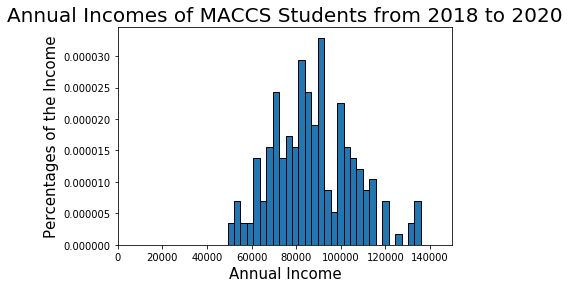

In [31]:
#1a
import matplotlib.pyplot as plt
num_bins = 30
plt.hist(df['Income'], num_bins, normed = True, edgecolor = 'k')
plt.xlabel('Annual Income', fontsize = 15)
plt.ylabel('Percentages of the Income', fontsize = 15)
plt.title('Annual Incomes of MACCS Students from 2018 to 2020', fontsize = 20)
plt.xlim([0, 150000])

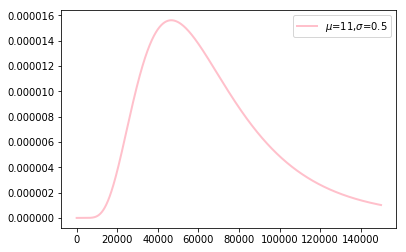

In [32]:
#1b
import numpy as np
import scipy.stats as sts

def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma,scale=np.exp(mu)))
            
    pdf_vals = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                 np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                 prob_notcut)
    
    return pdf_vals

dist_pts = np.linspace(1, 150000, 5000)
mu_1 = 11
sig_1 = 0.5
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_1,sig_1, 0, 150000),
         linewidth=2, color='pink', label='$\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper right')


In [6]:
# Define log likelihood function for the normal distribution
def log_lik_trunclognorm(xvals, mu, sigma, cut_lb, cut_ub):

    pdf_vals = trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood:', log_lik_trunclognorm(df['Income'], mu_1, sig_1, 0, 150000))

Log-likelihood: -2379.120591931827


In [7]:
#c Estimate the parameters of the lognormal distribution by maximum likeli-
#hood and plot its PDF against the PDF from part (b) and the histogram
#from part (a).
import scipy.optimize as opt

def crit(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub = args
    log_lik_val = log_lik_trunclognorm(xvals, mu, abs(sigma), cut_lb, cut_ub)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [8]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
mle_args = (df['Income'], 0, 150000)
results_uncstr = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE, sig_MLE = results_uncstr.x
print('ML estimates for mu is', mu_MLE)
print('ML estimates for sigma is', sig_MLE)
print('log likelihood maximization is',log_lik_trunclognorm(df['Income'], mu_MLE, sig_MLE, 0, 150000))

ML estimates for mu is 11.361699965967007
ML estimates for sigma is 0.21174326386681536
log likelihood maximization is -2240.934337511636


(0, 150000)

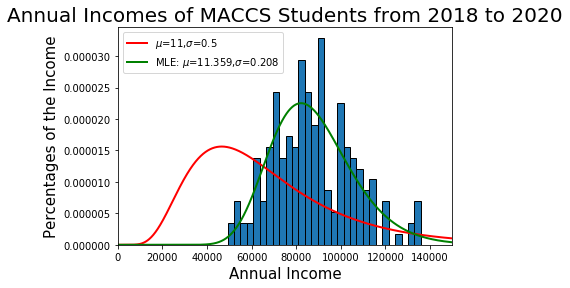

In [9]:
plt.hist(df['Income'], num_bins, normed = True, edgecolor = 'k')
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_1, sig_1, 0, 150000),
         linewidth=2, color='r', label='$\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_MLE,sig_MLE, 0, 150000),
         linewidth=2, color='g', label='MLE: $\mu$=11.359,$\sigma$=0.208')
plt.legend(loc='upper left')
plt.xlabel('Annual Income', fontsize = 15)
plt.ylabel('Percentages of the Income', fontsize = 15)
plt.title('Annual Incomes of MACCS Students from 2018 to 2020', fontsize = 20)
plt.xlim([0, 150000])

In [10]:
vcv_mle = results_uncstr.hess_inv

stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)
print('mu percent', stderr_mu_mle/mu_MLE)
print('sig percent', stderr_sig_mle/sig_MLE)

VCV(MLE) =  [[ 2.05516896e-04 -1.58272274e-05]
 [-1.58272274e-05  9.92889787e-05]]
Standard error for mu estimate =  0.014335860496126812
Standard error for sigma estimate =  0.009964385515514781
mu percent 0.001261770733170973
sig percent 0.0470588076028822


In [11]:
#d Perform a likelihood ratio test

log_lik_h0 = log_lik_trunclognorm(df['Income'], mu_1, sig_1, 0, 150000)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_trunclognorm(df['Income'], mu_MLE, sig_MLE, 0, 150000)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2379.120591931827
MLE log likelihood -2240.934337511636
likelihood ratio value 276.3725088403826
chi squared of H0 with 2 degrees of freedom p-value =  0.0


In [12]:
# since p value is extreme small, we can reject the null hypothesis

#1e Using that estimated model from part (c),
#What is the probability that you will earn more than $100,000? What is
#the probability that you will earn less than $75,000?

1-sts.lognorm.cdf(100000, sig_MLE, scale=np.exp(mu_MLE))

0.23755400684543593

The probability that MACSS graduates will earn more than $100000 is 23.76%.

In [14]:
sts.lognorm.cdf(75000, sig_MLE, scale=np.exp(mu_MLE))

0.2596439369860366

The probability that MACSS graduates will earn less than $75000 is 25.96%.

# Question 2

In [16]:
# q2a
import scipy.optimize as opt

df=pd.read_csv("sick.txt").astype('float64')
df.head()


,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [17]:
#2a Estimate the parameters of the model by max likelihood
def normal_distribution(xvals, sigma):
    sigma = abs(sigma)
    pdf_values = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(xvals) ** 2 / (2 * sigma ** 2))                  
    return pdf_values

def log_lik_normal(y, x1, x2, x3, beta0, beta1, beta2, beta3, sigma):
    error = y - beta0 - beta1 * x1 - beta2 * x2 - beta3 * x3
    pdf_values = normal_distribution(error, sigma)
    pdf_vals = np.log(pdf_values)
    log_lik_values = pdf_vals.sum()
    
    return log_lik_values

def crit_1(params,*args):
    
    beta0, beta1, beta2, beta3, sigma = params
    y, x1, x2, x3 = args
    log_lik_values = log_lik_normal(y, x1, x2, x3, beta0, beta1, beta2, beta3, sigma)
    neg_log_lik_val = -log_lik_values 
    
    return neg_log_lik_val

y=df['sick']

beta0_init, beta1_init, beta2_init, beta3_init, sigma_init = (0, 0, 0, 0, 1)
x1, x2, x3 = df['age'], df['children'], df['avgtemp_winter']
params_init = np.array([beta0_init, beta1_init, beta2_init, beta3_init, sigma_init])
results = opt.minimize(crit_1, params_init,(y, x1, x2, x3))
beta0_MLE, beta1_MLE, beta2_MLE, beta3_MLE, sigma_MLE = results.x
print('beta 0 is', beta0_MLE)
print('beta 1 is', beta1_MLE)
print('beta 2 is', beta2_MLE)
print('beta 3 is', beta3_MLE)
print('sigma is', sigma_MLE)
print("the log likelihood value is",-results.fun)

beta 0 is 0.251646963768576
beta 1 is 0.012933403043275343
beta 2 is 0.4005015615268546
beta 3 is -0.009991713968585248
sigma is 0.003017766027112541
the log likelihood value is 876.8650470218196


In [18]:
vcv_mle = results.hess_inv
print('vcv(MLE) =', vcv_mle)

vcv(MLE) = [[ 8.95220732e-07  1.18060705e-08 -2.02774294e-07 -2.27656435e-08
   3.36234635e-09]
 [ 1.18060705e-08  3.89770154e-09 -3.43642499e-08 -2.55579432e-09
   2.11698918e-11]
 [-2.02774294e-07 -3.43642499e-08  3.56241307e-07  2.27346736e-08
  -1.86687499e-09]
 [-2.27656435e-08 -2.55579432e-09  2.27346736e-08  2.01821875e-09
  -4.81914135e-11]
 [ 3.36234635e-09  2.11698918e-11 -1.86687499e-09 -4.81914135e-11
   2.31587509e-08]]


Text(0.5,1,'Histogram of epsilons')

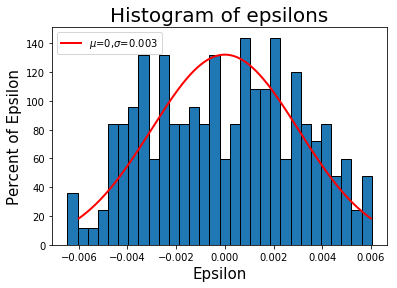

In [19]:
plt.hist(y-beta0_MLE-beta1_MLE*x1-beta2_MLE*x2-beta3_MLE*x3, num_bins, normed=True, edgecolor='k')
dist_pts=np.linspace(-0.006,0.006,3000)
plt.plot(dist_pts, normal_distribution(dist_pts, sigma_MLE),
         linewidth=2, color='r', label='$\mu$=0,$\sigma$=0.003')
plt.legend(loc='upper left')
plt.xlabel('Epsilon', fontsize = 15)
plt.ylabel('Percent of Epsilon', fontsize = 15)
plt.title('Histogram of epsilons', fontsize=20)

In [20]:
#2b Use a likelihood ratio test to determine the probability that B0 = 1:0,B2 = 0:01 and B1; B2; B3 = 0.
beta0_test, beta1_test, beta2_test, beta3_test, sigma_test = 1, 0, 0, 0, 0.1
log_lik_h0 = log_lik_normal(y, x1, x2, x3, beta0_test, beta1_test, beta2_test, beta3_test, sigma_test)
print('MLE log likelihood is', -results.fun)
print('hypothesis value log likelihood is', log_lik_h0)

MLE log likelihood is 876.8650470218196
hypothesis value log likelihood is -2253.700688042125


In [21]:
LR_val = 2 * ((-results.fun)-log_lik_h0)
print('likelihood ratio value is', LR_val)

likelihood ratio value is 6261.131470127889


In [22]:
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 5)
print('p-value is ', pval_h0)

p-value is  0.0


Since the p value is 0, we can reject the null hypothesis which means age, number of children, and average winter temperature have no effect on the number of sick days.
The likelihood that age, number of children, and average winter temperature have no effect on the number of sick days is zero?
